In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# parse names file and randomly shuffle it
words = open("names.txt", "r").read().splitlines()
random.seed(42)
random.shuffle(words)

In [3]:
# vocabulary and character to idx map
V = sorted(list(set(''.join(words))) + ['.'])
stoi = {s:i for i, s in enumerate(V)}
itos = {i:s for s, i in stoi.items()}

In [4]:
g = torch.Generator().manual_seed(2147483647)

In [5]:
# hyperparameters
block_size = 4
embedding_size = 20
hidden_layer_size = 200
epochs = 100000
minibatch_size = 64
learning_rate = 0.1
lr_decay_factor = 10

In [6]:
# create db
n1, n2 = int(0.8*len(words)), int(0.9*len(words))

def split_data(W):
    X, y = [], []
    for word in W:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

X_train, y_train = split_data(words[:n1])
X_dev, y_dev = split_data(words[n1:n2])
X_test, y_test = split_data(words[n2:])

In [7]:
# PyTorch implementation without using nn.Module
class Linear:
    def __init__(self, fan_in, fan_out, gain=5/3, bias=True):
        self.weights = gain * torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        out = x @ self.weights
        if self.bias is not None:
            out += self.bias
        return out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

In [8]:
# batchnorm layer
class BatchNorm1d:
    def __init__(self, num_features, momentum, eps=1e-05):
        self.eps = eps
        self.training = True
        self.momentum = momentum
        # parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # buffers
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
    def __call__(self, x):
        if self.training:
            bmean = x.mean(0, keepdim=True) # batch mean
            bvar = x.var(0, keepdim=True) # batch variance
        else:
            bmean = self.running_mean
            bvar = self.running_var
        xhat = (x - bmean) / torch.sqrt(bvar + self.eps)
        out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * bmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * bvar
        return out
    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
# tanh layer
class Tanh:
    def __call__(self, x):
        out = torch.tanh(x)
        return out
    def parameters(self):
        return []

In [10]:
# embedding
E = torch.randn((len(V), embedding_size), generator=g)

In [11]:
# neural net
Layers = [
    Linear(block_size * embedding_size, hidden_layer_size, bias=False),
    BatchNorm1d(hidden_layer_size, momentum=0.01),
    Tanh(),
    Linear(hidden_layer_size, len(V), bias=True)
]
with torch.no_grad():
    Layers[-1].weights * 0.01

In [12]:
parameters = [E] + [p for layer in Layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

Epoch: 0/100000: 4.0073
Epoch: 10000/100000: 1.9218
Epoch: 20000/100000: 2.1048
Epoch: 30000/100000: 1.8048
Epoch: 40000/100000: 2.0005
Epoch: 50000/100000: 2.1904
Epoch: 60000/100000: 1.8919
Epoch: 70000/100000: 1.8936
Epoch: 80000/100000: 1.8058
Epoch: 90000/100000: 1.8027


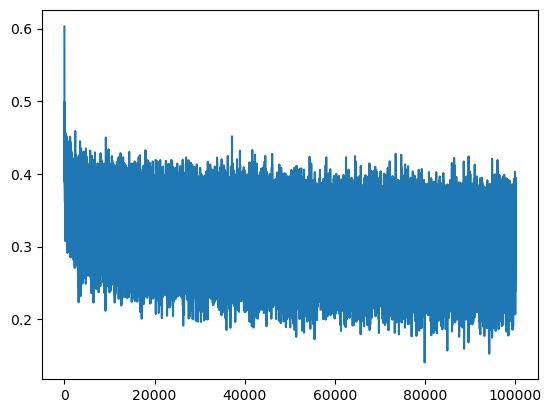

In [13]:
# train
lossi = []
stepi = []
for epoch in range(epochs):
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,), generator=g)
    Xb, yb = X_train[ix], y_train[ix]
    
    # forward pass
    emb = E[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in Layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        lr = learning_rate
        if epoch > int(0.9*epochs):
            lr /= lr_decay_factor
        p.data += -learning_rate * p.grad
    stepi.append(epoch)
    lossi.append(loss.log10().item())
    if epoch%10000 == 0:
        print(f'Epoch: {epoch}/{epochs}: {loss.item():.4f}')
plt.plot(stepi, lossi);

In [17]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    emb = E[X]
    x = emb.view(emb.shape[0], -1)
    for layer in Layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in Layers:
    layer.training = False
split_loss('train')
split_loss('dev')
split_loss('test')

train 1.9649356603622437
dev 2.0752499103546143
test 2.0656399726867676


In [19]:
# Sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = E[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in Layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

nailah.
daubella.
zidre.
caiven.
khristollyntheucentro.
aayaan.
zhya.
pelen.
camariela.
ki.
gracerine.
trace.
donsy.
alian.
dempino.
nora.
camilo.
mio.
drivitaluton.
vyrel.


In [13]:
# PyTorch implementation using nn.Module
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(len(V), embedding_size)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size*block_size, hidden_layer_size, bias=False),
            nn.BatchNorm1d(hidden_layer_size, momentum=0.01),
            nn.Tanh(),
            nn.Linear(hidden_layer_size, len(V))
        )
    def forward(self, idx, targets = None):
        emb = self.wte(idx)
        emb = emb.view(idx.shape[0], -1)
        logits = self.mlp(emb)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)
        return logits, loss

In [15]:
model = MLP()

In [17]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
def kaiming_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity="tanh", generator=g)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
def close_zero_init(m):
     if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, gain=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
model.mlp[0].apply(kaiming_init)
model.mlp[-1].apply(close_zero_init)

Linear(in_features=200, out_features=27, bias=True)

In [19]:
lossi = []
stepi = []
for epoch in range(epochs):
    # minibatch
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,), generator=g)
    Xb, yb = X_train[ix], y_train[ix]
    
    # forward
    logits, loss = model(Xb, yb)
    
    # backward
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    stepi.append(epoch)
    lossi.append(loss.log10().item())
    if epoch%10000 == 0:
        print(f'Epoch: {epoch}/{epochs}: {loss.item():.4f}')

Epoch: 0/100000: 3.2766
Epoch: 10000/100000: 2.2347
Epoch: 20000/100000: 2.0497
Epoch: 30000/100000: 1.7637
Epoch: 40000/100000: 1.8826
Epoch: 50000/100000: 2.2014
Epoch: 60000/100000: 2.1449
Epoch: 70000/100000: 1.9384
Epoch: 80000/100000: 2.3577
Epoch: 90000/100000: 2.2147


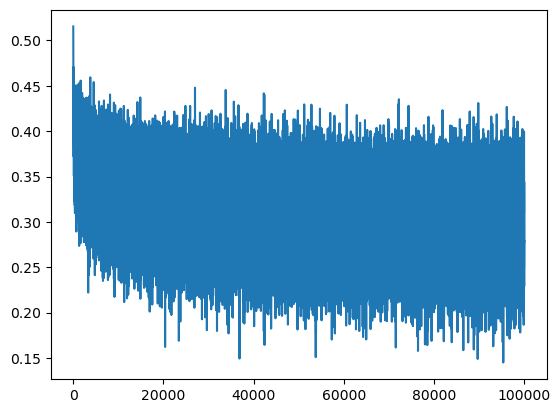

In [26]:
plt.plot(stepi, lossi);

In [36]:
model.eval()

MLP(
  (wte): Embedding(27, 20)
  (mlp): Sequential(
    (0): Linear(in_features=80, out_features=200, bias=False)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=27, bias=True)
  )
)

In [38]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    logits, loss = model(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 1.9662977457046509
dev 2.0795669555664062
test 2.073986530303955


In [47]:
# Sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits[0], dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

jaxley.
onali.
amara.
dailyn.
nikha.
dariam.
braycee.
dani.
nika.
aashlynn.
melle.
zamya.
kamae.
lyne.
alonner.
mona.
conne.
harchellca.
bubby.
enaillianna.
